In [1]:
from transformers import AutoModelForCausalLM
from auto_circuit.utils.graph_utils import patch_mode, patchable_model
from dataclasses import dataclass
from torch import Tensor
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import numpy as np
import random
from datasets import ClassLabel, Dataset, DatasetDict, Features, Image, load_from_disk
from einops import rearrange
from torch.distributions import MultivariateNormal
from pathlib import Path
from typing import Callable
import pickle

import pandas as pd

from transformer_lens import HookedTransformer, HookedTransformerConfig

from auto_circuit.utils.ablation_activations import batch_src_ablations
from auto_circuit.data import PromptDataset, PromptDataLoader
from auto_circuit.types import AblationType

from concept_erasure import QuadraticEditor, QuadraticFitter
from concept_erasure.utils import assert_type
from concept_erasure.quantile import QuantileNormalizer

import time

In [2]:
device = "cuda"

def load_with_retries(model_name: str, revision: str, model_size: int):
    for retry in range(3):
        try:
            model = HookedTransformer.from_pretrained(
                model_name,
                torch_dtype=torch.float32,
                revision=revision,
                cache_dir=".cache",
                quantization_config=BitsAndBytesConfig(load_in_4bit=True) if model_size > 6e9 else None
            ).cuda()
            return model
        except Exception as e:
            if retry < 2:
                print(f"Attempt {retry + 1} failed, retrying in 2 seconds...", e)
                time.sleep(2)
            else:
                return None


%pdb on
model_path = "EleutherAI/pythia-160m"
revision1 = "step128"
revision2 = "step256"
model1 = load_with_retries(model_path, revision1, 14000000)
model2 = load_with_retries(model_path, revision2, 14000000)

model1.set_use_attn_result(True)
model2.set_use_attn_result(True)
model1.set_use_hook_mlp_in(True)
model2.set_use_hook_mlp_in(True)
model1.set_use_split_qkv_input(True)
model2.set_use_split_qkv_input(True)

model1 = patchable_model(model1, factorized=True, device=device, separate_qkv=True)
model2 = patchable_model(model2, factorized=True, device=device, separate_qkv=True)

Automatic pdb calling has been turned ON


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model EleutherAI/pythia-160m into HookedTransformer
Moving model to device:  cuda


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model EleutherAI/pythia-160m into HookedTransformer
Moving model to device:  cuda


In [3]:
ngrams_dataset_name = "/mnt/ssd-1/lucia/ngrams-across-time/data/val_tokenized.hf"

dataset = load_from_disk(ngrams_dataset_name)

top_tokens = pd.read_csv("/mnt/ssd-1/david/ngrams_across_time/data/top_kl_divs.csv")

weird_data = dataset[top_tokens.sample_idx]

answers = weird_data['input_ids'][range(len(weird_data)), top_tokens.token_idx].unsqueeze(1)
wrong_answers = []
for i, idx in enumerate(top_tokens.token_idx):
    logits = model1(weird_data['input_ids'][i, :idx+1])[:, -1, :2048]
    topk = torch.topk(logits, k=5, dim=-1).indices.squeeze()
    wrong_answers.append(topk)


pdset = PromptDataset(
    clean_prompts=weird_data['input_ids'][:, :2048],
    corrupt_prompts=weird_data['input_ids'][:, :2048],
    answers=answers,
    wrong_answers=wrong_answers
)

In [10]:
ploader = PromptDataLoader(pdset, None, 0, batch_size=1, shuffle=True)
ablations = batch_src_ablations(model1, ploader, AblationType.RESAMPLE, 'clean')

In [14]:
ablations[-323570240853508540][0].sum()

tensor(-0.0001, device='cuda:0')

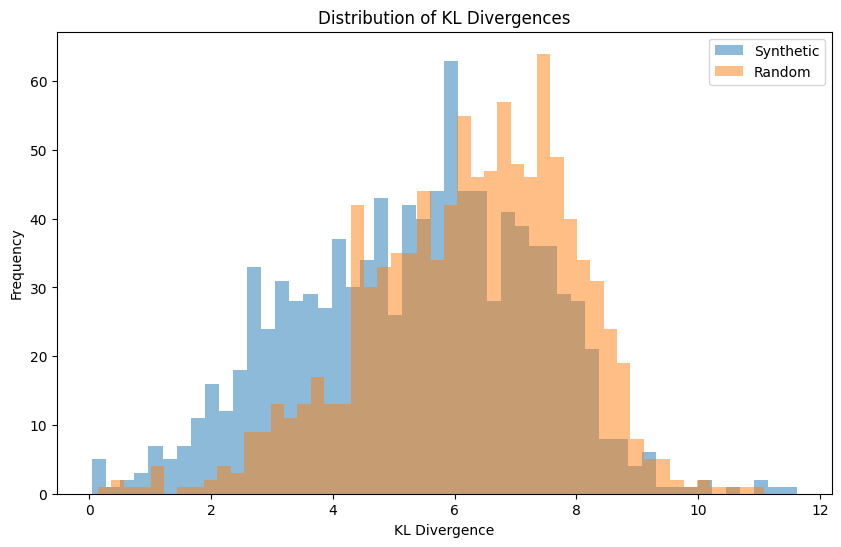

Synthetic KL Div: Mean = 5.3492, Std = 1.9712
Random KL Div: Mean = 6.2373, Std = 1.6852


In [9]:
import torch.nn.functional as F
import random

# Function to generate synthetic sequences
def generate_synthetic_sequence(dataset, weird_token, seq_length=2048):
    random_seq = dataset[random.randint(0, len(dataset)-1)]['input_ids'][:seq_length].clone()
    replace_idx = random.randint(0, seq_length-2)  # -2 to ensure there's a token after
    random_seq[replace_idx] = weird_token
    return random_seq, replace_idx

# Generate synthetic sequences
weird_token = weird_data['input_ids'][0, top_tokens.token_idx[0] - 1]
num_synthetic = 1000  # Number of synthetic sequences to generate
synthetic_seqs = [generate_synthetic_sequence(dataset, weird_token) for _ in range(num_synthetic)]

# Function to compute KL divergence
def compute_kl_div(p, q):
    return F.kl_div(F.log_softmax(p, dim=-1), F.softmax(q, dim=-1), reduction='batchmean')

# Compute logits for weird data
weird_logits = model2(weird_data['input_ids'][0, :top_tokens.token_idx[0]+1].unsqueeze(0))[:, -1, :]

# Compute KL divergences for synthetic sequences
synthetic_kl_divs = []
for seq, idx in synthetic_seqs:
    logits = model2(seq.unsqueeze(0))[:, idx + 1, :]
    kl_div = compute_kl_div(logits, weird_logits)
    synthetic_kl_divs.append(kl_div.item())

# Compute KL divergences for random samples
random_kl_divs = []
for _, idx in synthetic_seqs:
    random_seq = dataset[random.randint(0, len(dataset)-1)]['input_ids'][:2048]
    logits = model2(random_seq.unsqueeze(0))[:, idx + 1, :]
    kl_div = compute_kl_div(logits, weird_logits)
    random_kl_divs.append(kl_div.item())

# Compare distributions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(synthetic_kl_divs, bins=50, alpha=0.5, label='Synthetic')
plt.hist(random_kl_divs, bins=50, alpha=0.5, label='Random')
plt.xlabel('KL Divergence')
plt.ylabel('Frequency')
plt.title('Distribution of KL Divergences')
plt.legend()
plt.show()

# Print summary statistics
print(f"Synthetic KL Div: Mean = {np.mean(synthetic_kl_divs):.4f}, Std = {np.std(synthetic_kl_divs):.4f}")
print(f"Random KL Div: Mean = {np.mean(random_kl_divs):.4f}, Std = {np.std(random_kl_divs):.4f}")

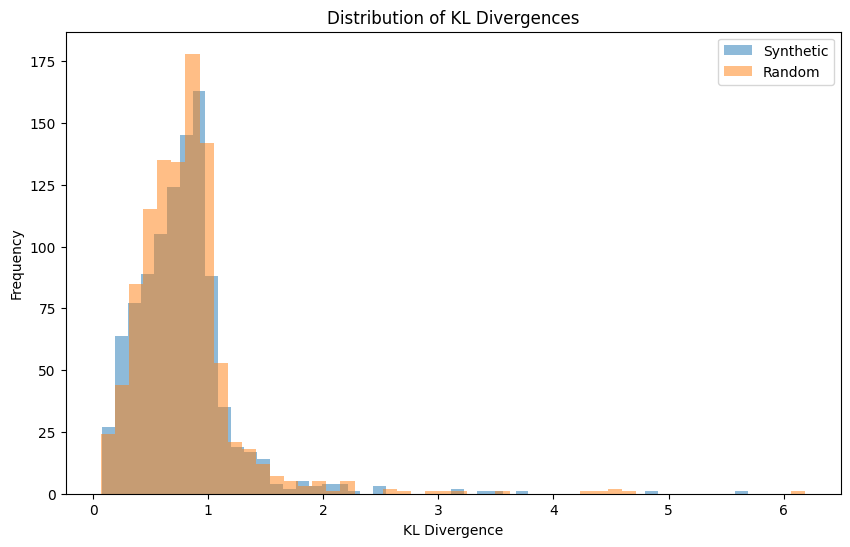

Synthetic KL Div: Mean = 0.7817, Std = 0.4477
Random KL Div: Mean = 0.8057, Std = 0.4890


In [10]:
# Generate synthetic sequences
weird_token = weird_data['input_ids'][0, top_tokens.token_idx[0] - 1]
num_synthetic = 1000  # Number of synthetic sequences to generate
synthetic_seqs = [generate_synthetic_sequence(dataset, weird_token) for _ in range(num_synthetic)]

# Compute logits for weird data
weird_logits = model1(weird_data['input_ids'][0, :top_tokens.token_idx[0]+1].unsqueeze(0))[:, -1, :]

# Compute KL divergences for synthetic sequences
synthetic_kl_divs = []
for seq, idx in synthetic_seqs:
    logits = model1(seq.unsqueeze(0))[:, idx + 1, :]
    kl_div = compute_kl_div(logits, weird_logits)
    synthetic_kl_divs.append(kl_div.item())

# Compute KL divergences for random samples
random_kl_divs = []
for _, idx in synthetic_seqs:
    random_seq = dataset[random.randint(0, len(dataset)-1)]['input_ids'][:2048]
    logits = model1(random_seq.unsqueeze(0))[:, idx + 1, :]
    kl_div = compute_kl_div(logits, weird_logits)
    random_kl_divs.append(kl_div.item())

# Compare distributions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(synthetic_kl_divs, bins=50, alpha=0.5, label='Synthetic')
plt.hist(random_kl_divs, bins=50, alpha=0.5, label='Random')
plt.xlabel('KL Divergence')
plt.ylabel('Frequency')
plt.title('Distribution of KL Divergences')
plt.legend()
plt.show()

# Print summary statistics
print(f"Synthetic KL Div: Mean = {np.mean(synthetic_kl_divs):.4f}, Std = {np.std(synthetic_kl_divs):.4f}")
print(f"Random KL Div: Mean = {np.mean(random_kl_divs):.4f}, Std = {np.std(random_kl_divs):.4f}")